# Dự đoán giá chứng khoán trong 14 ngày tiếp theo của TRA
---

## 1. Import thư viện
---

In [1]:
import pandas as pd 

import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

# vẽ biểu đồ cho ngầu 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

# xử lý thời gian 
from datetime import datetime

# keras for LSTM 
# phải cài cái này 
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, SimpleRNN
from keras.layers.convolutional import Conv1D, Conv2D

#Thu vien đo thời gian
import time

## 2. Download data
---

In [2]:
# df = DataReader('AMZN', data_source='yahoo', start='2009-01-01', end='2019-12-31')
# df
df = pd.read_csv('Data co phieu (8).csv')
df = df.set_index('Ngay')
df

,Thay doi,Mo cua,Cao nhat,Thap nhat,Dong cua,Trung binh,Dong cua DC,Khoi luong
Ngay,,,,,,,,
16/07/2015,0.00 / 0.00%,83.0,83.0,83.0,83.0,83.00,37.41,170
17/07/2015,0.00 / 0.00%,83.0,83.5,83.0,83.0,83.19,37.41,1.19
20/07/2015,0.00 / 0.00%,83.0,83.0,83.0,83.0,83.00,37.41,0
21/07/2015,83.33333333,82.0,82.0,82.0,82.0,82.00,36.96,5.64
22/07/2015,0.00 / 0.00%,82.0,82.0,82.0,82.0,82.00,36.96,0
...,...,...,...,...,...,...,...,...
14/11/2022,91.74311927,94.9,94.9,91.0,91.0,91.13,89.02,3.6
15/11/2022,0.00 / 0.00%,90.9,91.0,90.0,91.0,90.69,89.02,5.2
16/11/2022,90.90909091,84.7,92.7,84.7,91.9,87.21,89.90,5.1


In [3]:
df.shape

(1840, 8)

## 3. Chia tập dữ liệu để làm việc
---

In [4]:
def splitDataset(df):
    length = df.shape[0]
    train_df = df[:length - 14]
    test_df = df[length - 14:]
    return train_df, test_df

train_df, test_df = splitDataset(df)
print(test_df)

train_df.shape, test_df.shape

                Thay doi  Mo cua  Cao nhat  Thap nhat  Dong cua  Trung binh  \
Ngay                                                                          
1/11/2022    92.78350515    93.1      93.9       93.0      93.9       93.21   
2/11/2022    94.05940594    93.9      96.0       93.6      95.8       94.76   
3/11/2022    95.74468085    95.0      95.0       94.8      94.9       94.89   
4/11/2022             95    94.8      94.9       93.0      93.0       94.62   
7/11/2022    93.02325581    93.5      97.0       93.5      97.0       94.42   
8/11/2022    97.08737864    95.7      95.7       93.0      94.0       94.48   
9/11/2022    94.11764706    94.0      94.8       93.9      94.8       94.23   
10/11/2022   94.73684211    94.0      94.0       88.8      93.0       93.25   
11/11/2022   92.59259259    87.1      93.0       87.1      92.0       91.85   
14/11/2022   91.74311927    94.9      94.9       91.0      91.0       91.13   
15/11/2022  0.00 / 0.00%    90.9      91.0       90.

((1826, 8), (14, 8))

## 4. Tiền xử lý tập train và tạo `preprocess_pipeline`
---

In [5]:
# tạo dataframe chỉ bao gồm cột index và cột Adj Close Price 
def createDataFrame(df):
    return df.filter(['Dong cua'])

real_train_df = createDataFrame(train_df)
real_train_df.shape

(1826, 1)

In [6]:
# scale dữ liệu train
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(real_train_df)

def reshapeForModel(scaled_train_data):
    return scaled_train_data.reshape((-1,))

scaled_train_data = reshapeForModel(scaled_train_data)
scaled_train_data.shape
print(scaled_train_data)

[0.38883035 0.38883035 0.38883035 ... 0.51001054 0.51001054 0.49420443]


In [7]:
def reshapeForModelMLP(scaled_train_data):
    return scaled_train_data

scaled_train_data = reshapeForModelMLP(scaled_train_data)
scaled_train_data.shape

(1826,)

## Tạo data 

In [8]:
# tạo dữ liệu train_X và train_y cho RNN
def createTrainX_y_RNN(scaled_train_data, time_steps=840, out_length=14):
    train_X = []
    train_y = []
    for i in range(len(scaled_train_data) - time_steps - out_length + 1):
        end_X = i + time_steps
        end_y = end_X + out_length
        train_X.append(scaled_train_data[i:end_X])
        train_y.append(scaled_train_data[end_X:end_y])

    train_X, train_y = np.array(train_X), np.array(train_y)
    return train_X.reshape((train_X.shape[0], train_X.shape[1], 1)), train_y

train_X, train_y = createTrainX_y_RNN(scaled_train_data)
train_X.shape, train_y.shape

((973, 840, 1), (973, 14))

In [9]:
# tạo dữ liệu train_X và train_y
def createTrainX_y_MLP(scaled_train_data, time_steps=840, out_length=14):
    train_X = []
    train_y = []
    for i in range(len(scaled_train_data) - time_steps - out_length + 1):
        end_X = i + time_steps
        end_y = end_X + out_length
        train_X.append(scaled_train_data[i:end_X])
        train_y.append(scaled_train_data[end_X:end_y])

    train_X, train_y = np.array(train_X), np.array(train_y)
    return train_X.reshape((train_X.shape[0], train_X.shape[1])), train_y

train_X, train_y = createTrainX_y_MLP(scaled_train_data)
train_X.shape, train_y.shape

((973, 840), (973, 14))

## preprocess

In [10]:
preprocess_pipeline = Pipeline([
    ('dropper', FunctionTransformer(createDataFrame)),
    ('scaler', MinMaxScaler()),
    ('reshape', FunctionTransformer(reshapeForModel)),
    ('createTrain', FunctionTransformer(createTrainX_y_RNN)),
])

train_X1, train_y1 = preprocess_pipeline.fit_transform(train_df)
train_X1.shape, train_y.shape

((973, 840, 1), (973, 14))

In [11]:
preprocess_pipeline2 = Pipeline([
    ('dropper', FunctionTransformer(createDataFrame)),
    ('scaler', MinMaxScaler()),
    ('reshape', FunctionTransformer(reshapeForModelMLP)),
    ('createTrain', FunctionTransformer(createTrainX_y_MLP)),
])

train_X2, train_y2 = preprocess_pipeline2.fit_transform(train_df)
train_X2.shape, train_y2.shape

((973, 840), (973, 14, 1))

## 5. Tạo model
---

In [12]:
# Tạo RNN model 
def createModelRNN(train_X, time_steps=840, out_length=14):
    model = Sequential()
    model.add(SimpleRNN(200 ,return_sequences=True, activation='relu', input_shape=(train_X.shape[1], 1)))
    model.add(SimpleRNN(50,return_sequences=False, activation='relu',))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return model

In [13]:
# Tạo MLP model 
def createModelMLP(train_X, time_steps=840, out_length=14):
    model = Sequential()
#     model.add(Dense(500))
    model.add(Dense(200, activation='relu',))
    model.add(Dense(50, activation='relu',))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return model

## 6. `fit` model với tập train và predict tập test 
---

In [14]:
# build model RNN
model1 = createModelRNN(train_X1)
model1.summary()

time_start = time.time()

model1.fit(train_X1, train_y1, batch_size=1, epochs=1)

time_end = time.time()

time_train_RNN = time_end - time_start

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 840, 200)          40400     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                12550     
                                                                 
 dense (Dense)               (None, 14)                714       
                                                                 
Total params: 53,664
Trainable params: 53,664
Non-trainable params: 0
_________________________________________________________________
973/973 [==============================] - 218s 223ms/step - loss: 0.0028


In [15]:
# build model MLP
model2 = createModelMLP(train_X2)

time_start = time.time()

model2.fit(train_X2, train_y1, batch_size=1, epochs=2)

time_end = time.time()

time_train_MLP = time_end - time_start

model2.summary()


Epoch 1/2
973/973 [==============================] - 3s 3ms/step - loss: 0.0068
Epoch 2/2
973/973 [==============================] - 3s 3ms/step - loss: 0.0024
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (1, 200)                  168200    
                                                                 
 dense_2 (Dense)             (1, 50)                   10050     
                                                                 
 dense_3 (Dense)             (1, 14)                   714       
                                                                 
Total params: 178,964
Trainable params: 178,964
Non-trainable params: 0
_________________________________________________________________


In [16]:
# tạo tập test_inputs RNN
test_inputs = df[len(df) - len(test_df) - 840 :]
test_X1, test_y1 = preprocess_pipeline.transform(test_inputs)
test_X1.shape, test_y1.shape

((1, 840, 1), (1, 14))

In [17]:
# tạo tập test_inputs MLP
test_inputs = df[len(df) - len(test_df) - 840 :]
test_X2, test_y2 = preprocess_pipeline2.transform(test_inputs)
test_X2.shape, test_y2.shape

((1, 840), (1, 14, 1))

In [18]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu của RNN
time_start = time.time()

pred_test1 = model1.predict(test_X1)

time_end = time.time()

time_test_RNN = time_end - time_start

pred_test1 = scaler.inverse_transform(pred_test1)
pred_test1 = [round(i) for i in pred_test1[0]]
print(pred_test1)


1/1 [==============================] - 0s 384ms/step
[93, 92, 93, 92, 94, 93, 93, 91, 92, 91, 91, 93, 94, 93]


In [19]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu của MLP
time_start = time.time()

pred_test2 = model2.predict(test_X2)

time_end = time.time()

time_test_MLP = time_end - time_start

pred_test2 = scaler.inverse_transform(pred_test2)
pred_test2 = [round(i) for i in pred_test2[0]]
print(pred_test2)


1/1 [==============================] - 0s 75ms/step
[94, 94, 95, 95, 93, 94, 95, 97, 93, 94, 94, 93, 93, 94]


In [20]:
#Data test
length = df.shape[0]
test = df[length - 14:]['Dong cua'].values
print(test)

[93.9 95.8 94.9 93.  97.  94.  94.8 93.  92.  91.  91.  91.9 90.  90. ]


## Biểu đồ giá giữa Test và RNN

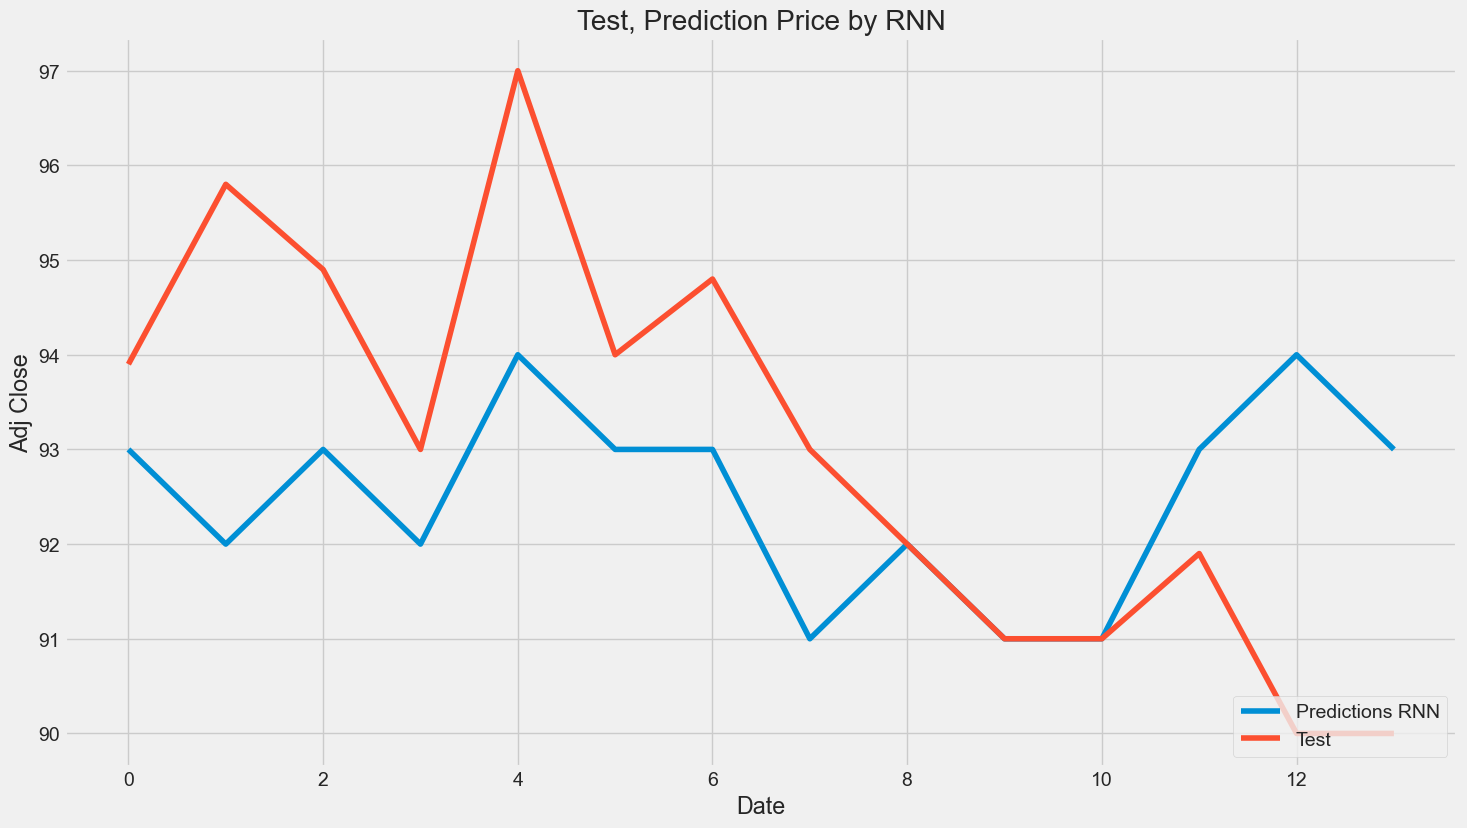

In [21]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price by RNN')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(pred_test1)

plt.plot(test)
plt.legend(['Predictions RNN','Test'], loc='lower right')
plt.show()

## Biểu đồ giá giữa Test và MLP

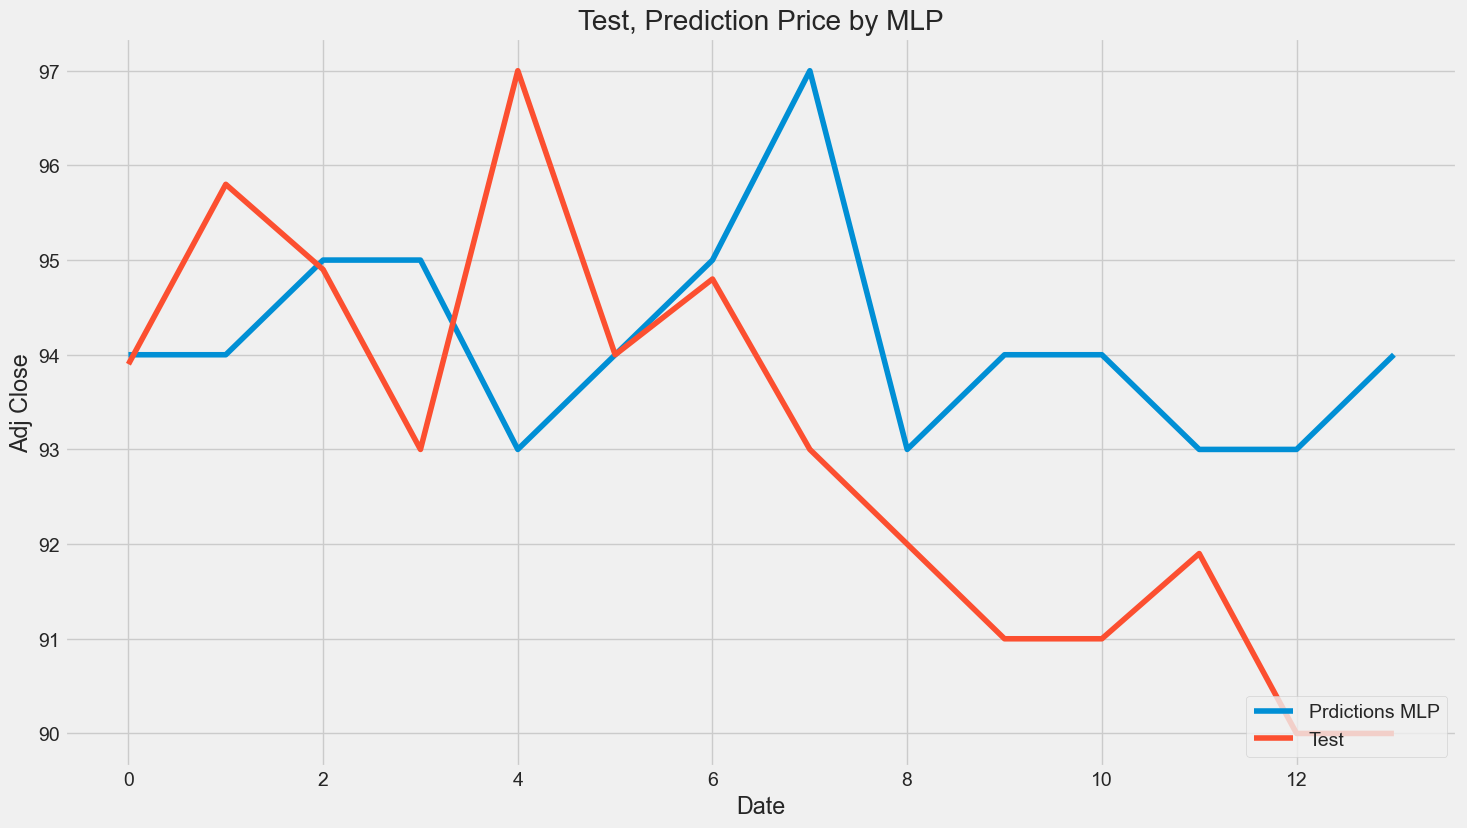

In [22]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price by MLP')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(pred_test2)

plt.plot(test)
plt.legend(['Prdictions MLP','Test'], loc='lower right')
plt.show()

## kNN

In [23]:
from sklearn.neighbors import KNeighborsRegressor

neigh = KNeighborsRegressor()

time_start = time.time()

neigh.fit(train_X2, train_y1)

time_end = time.time()

time_train_kNN = time_end - time_start

#Predict using kNN
time_start = time.time()

y_pred = neigh.predict(test_X2)

time_end = time.time()

time_test_kNN = time_end - time_start

In [24]:
pred_test3 = scaler.inverse_transform(y_pred)
print(pred_test3)

[[96.94 96.24 95.64 95.44 95.22 95.04 94.96 95.16 95.16 94.78 94.7  94.6
  94.3  93.9 ]]


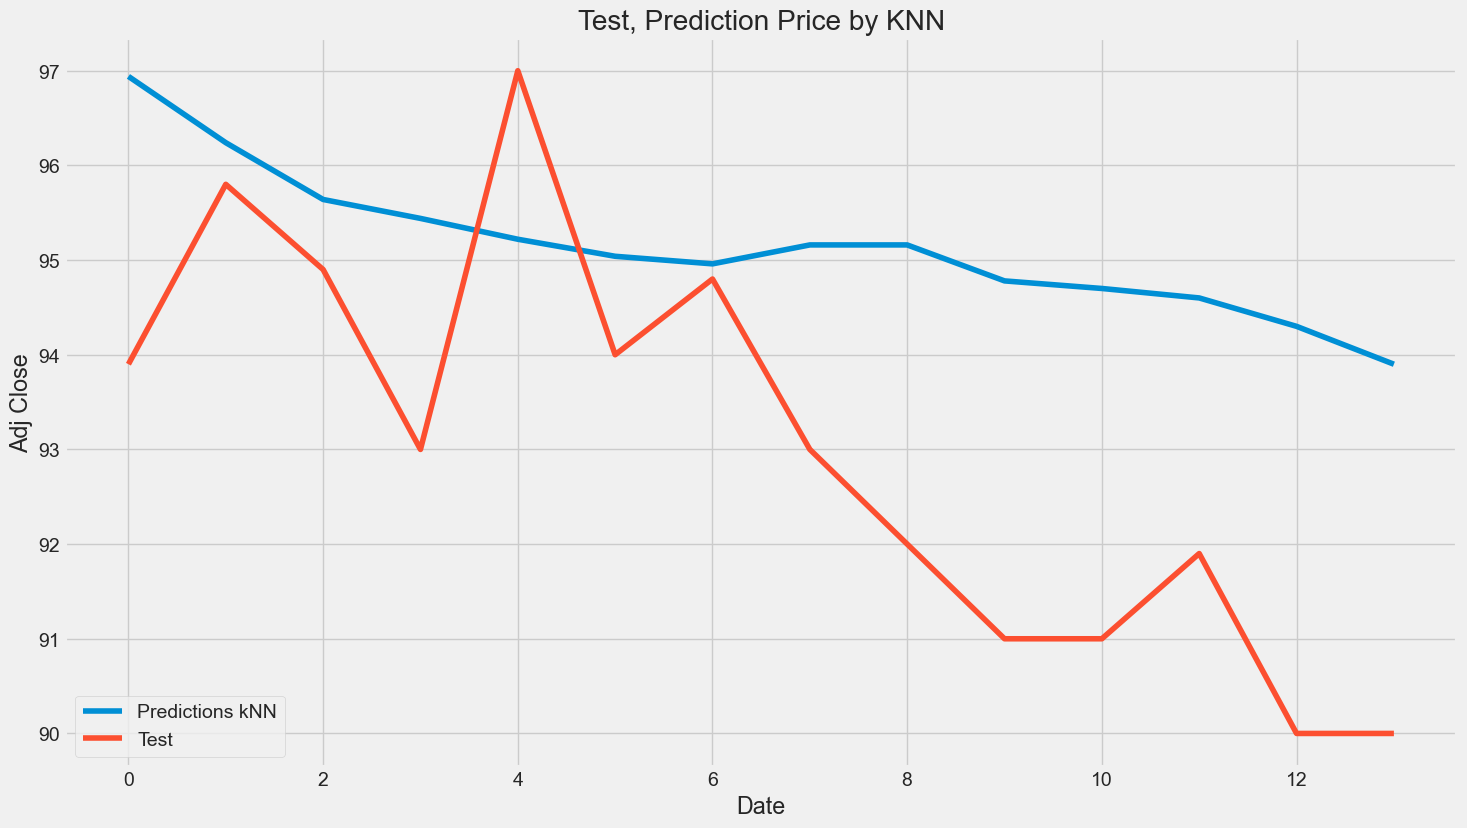

In [25]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price by KNN')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(pred_test3[0])

plt.plot(test)
plt.legend(['Predictions kNN','Test'], loc='lower left')
plt.show()

## Linear Regression

In [26]:
from sklearn.linear_model import LinearRegression

time_start = time.time()

reg = LinearRegression().fit(train_X2, train_y1)

time_end = time.time()

time_train_LN = time_end - time_start

##predict
time_start = time.time()

y_pred = reg.predict(test_X2)

time_end = time.time()

time_test_LN = time_end - time_start


In [27]:
pred_test4 = scaler.inverse_transform(y_pred)
print(pred_test4)

[[93.40043492 90.58194606 92.24513799 92.69591478 92.88814769 90.86784041
  90.52584978 85.28994118 87.07374251 85.33608814 87.75803073 85.60738323
  85.80459235 87.39507535]]


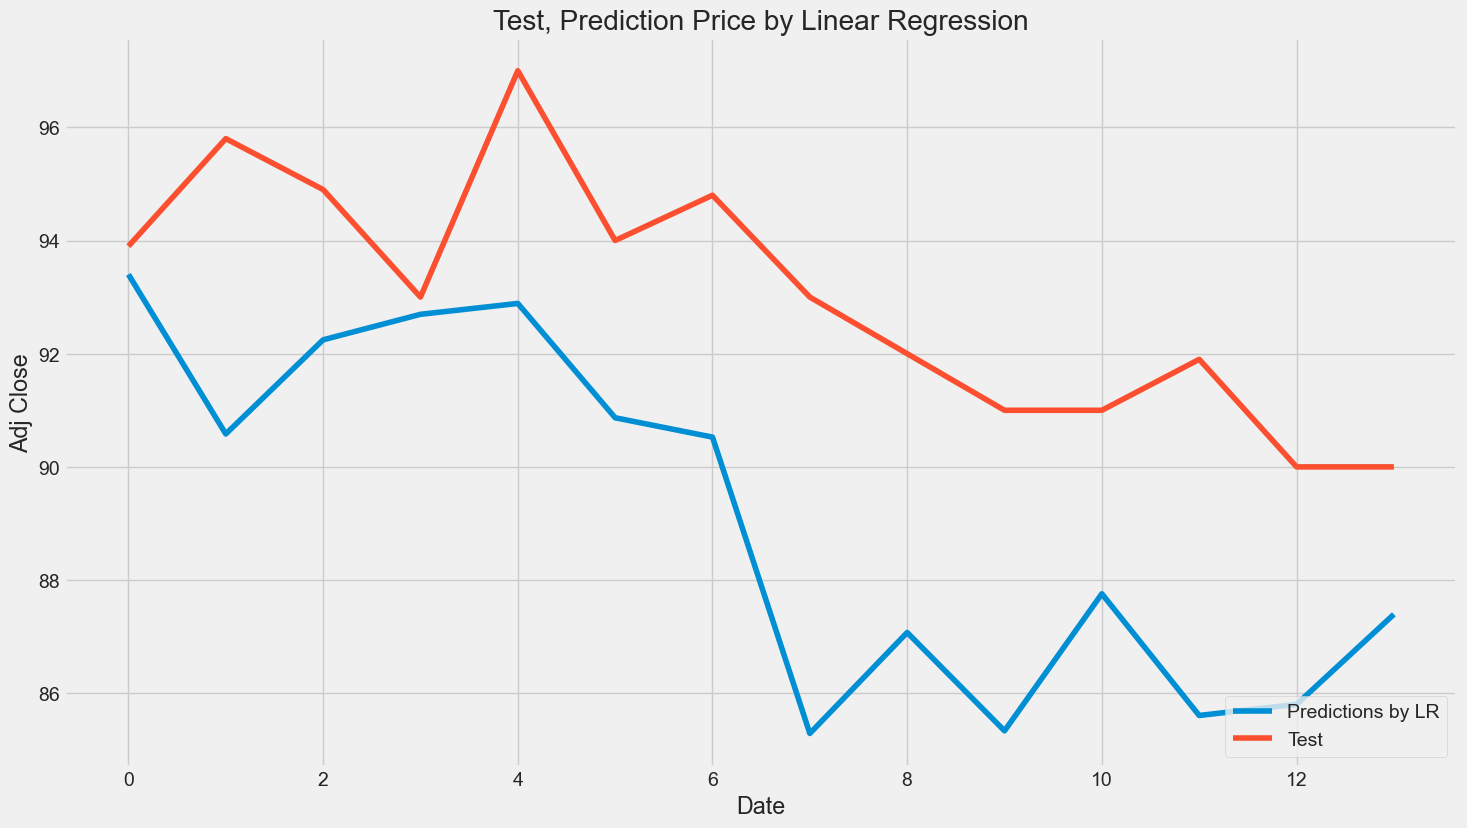

In [28]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price by Linear Regression')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(pred_test4[0])

plt.plot(test)
plt.legend(['Predictions by LR','Test'], loc='lower right')
plt.show()

## Biểu đồ so sánh giá giữa RNN, MLP, kNN và Linear Regression

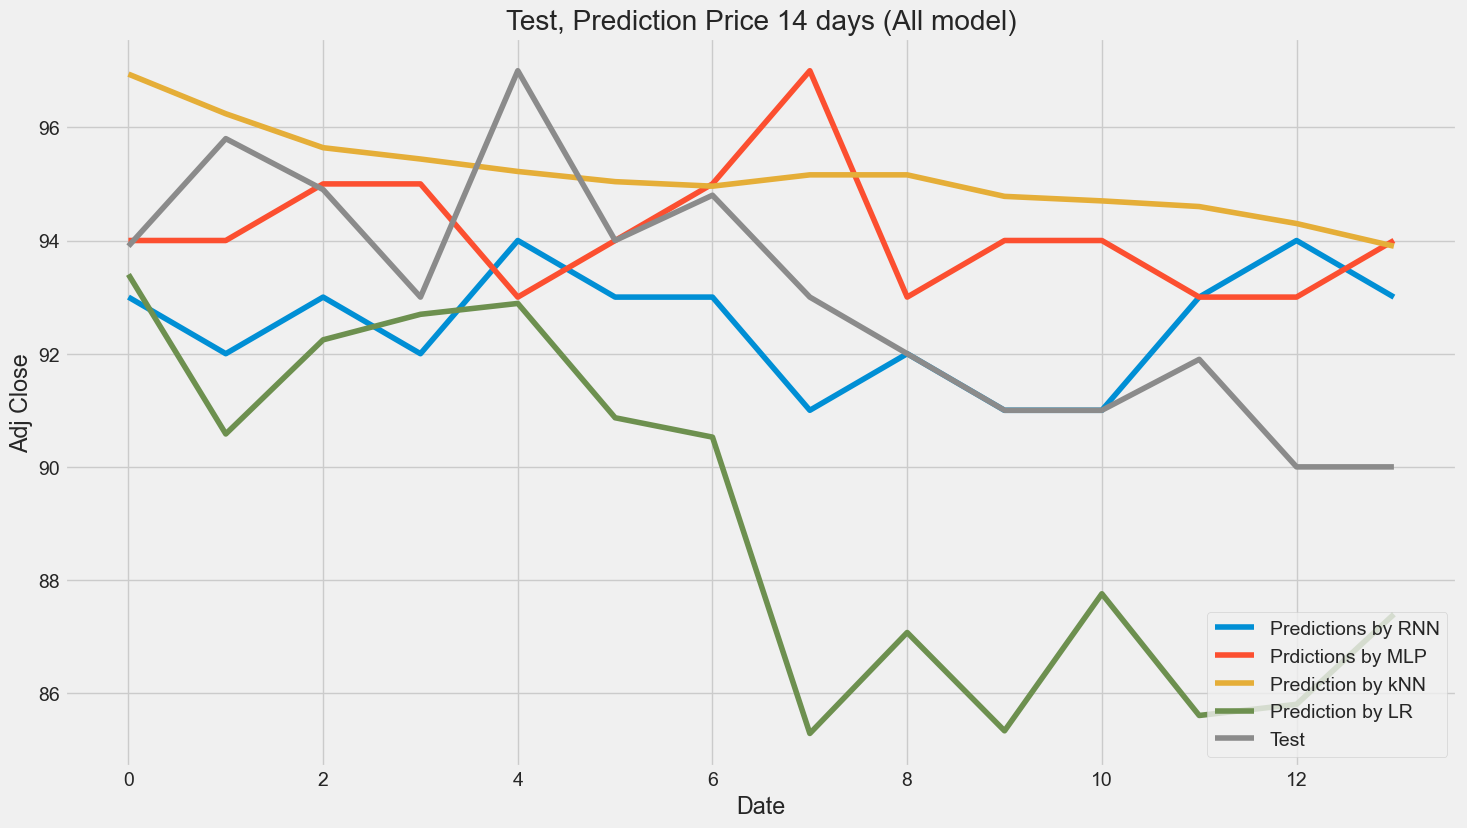

In [29]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price 14 days (All model)')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(pred_test1)
plt.plot(pred_test2)
plt.plot(pred_test3[0])
plt.plot(pred_test4[0])


plt.plot(test)
plt.legend(['Predictions by RNN','Prdictions by MLP','Prediction by kNN','Prediction by LR','Test'], loc='lower right')
plt.show()

## Thời gian train model

In [30]:
name = ['RNN', 'MLP', 'kNN', 'Linear Regression']

In [31]:
print("Thời gian train các model")
print("RNN: %.5f" %time_train_RNN)
print("MLP: %.5f" %time_train_MLP)
print("kNN: %.5f" %time_train_kNN)
print("LN: %.5f" %time_train_LN)

Thời gian train các model
RNN: 218.54786
MLP: 6.41862
kNN: 0.00201
LN: 0.15236


In [32]:
time_train = [time_train_RNN, time_train_MLP, time_train_kNN, time_train_LN]

<BarContainer object of 4 artists>

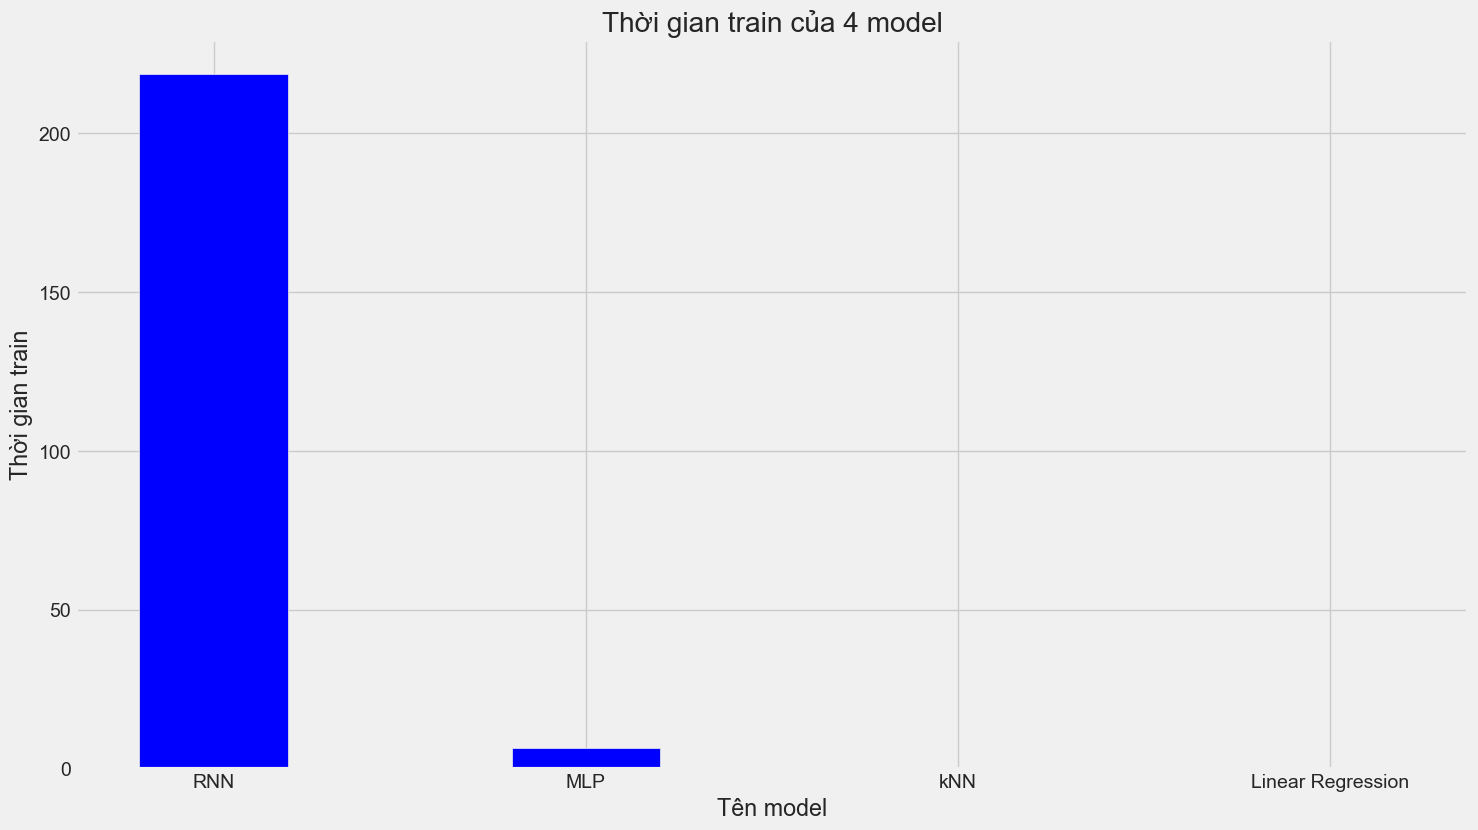

In [33]:
plt.figure(figsize=(16,9))
plt.title('Thời gian train của 4 model')
plt.xlabel('Tên model')
plt.ylabel('Thời gian train')
plt.bar(name, time_train, color ='blue',
        width = 0.4)

## Thời gian test model

In [34]:
print("Thời gian test các model")
print("RNN: %.5f" %time_test_RNN)
print("MLP: %.5f" %time_test_MLP)
print("kNN: %.5f" %time_test_kNN)
print("LN: %.5f" %time_test_LN)

Thời gian test các model
RNN: 0.46159
MLP: 0.12937
kNN: 0.00730
LN: 0.00000


In [35]:
time_test = [time_test_RNN, time_test_MLP, time_test_kNN, time_test_LN]

<BarContainer object of 4 artists>

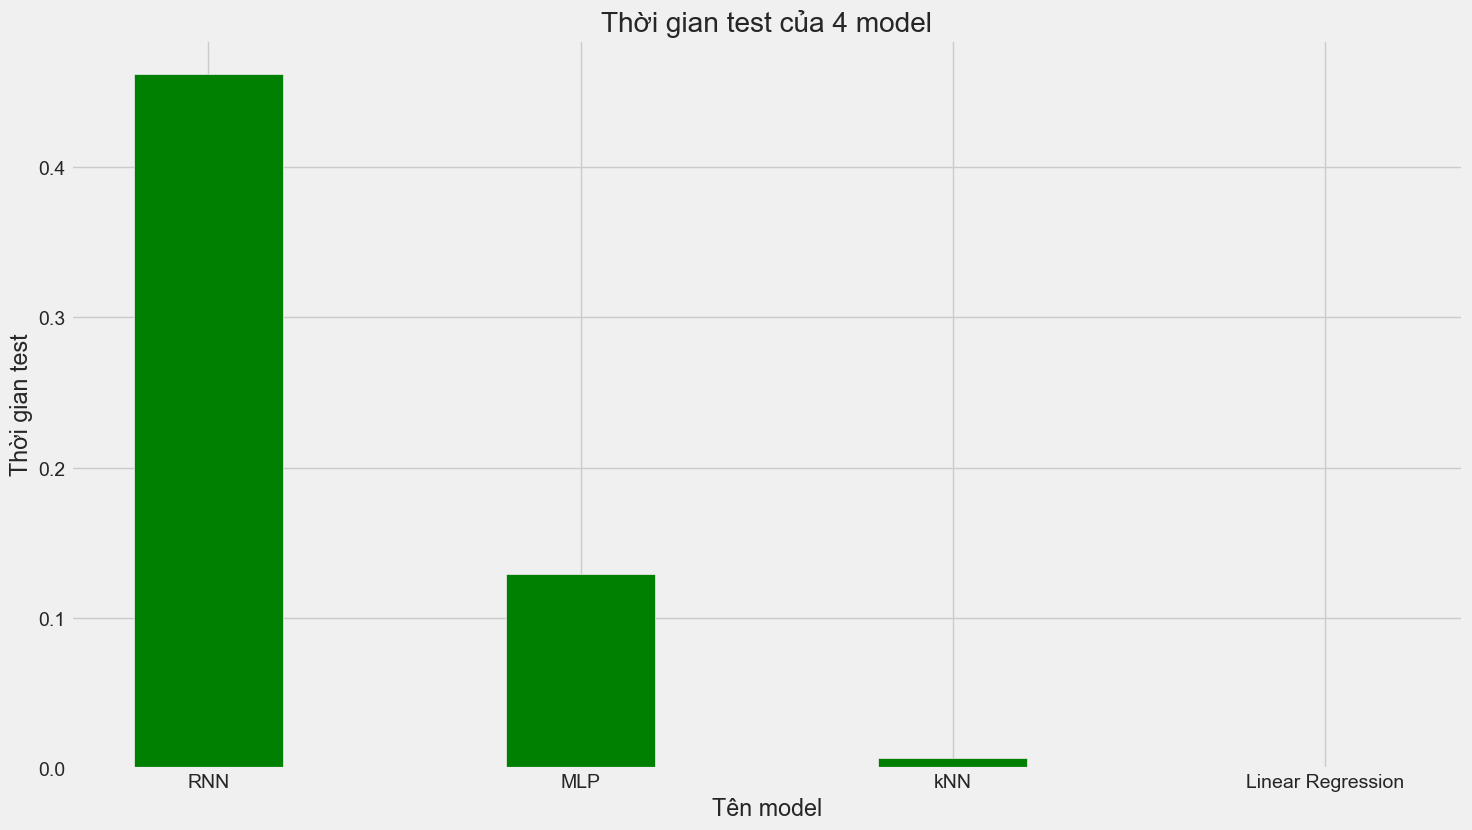

In [36]:
plt.figure(figsize=(16,9))
plt.title('Thời gian test của 4 model')
plt.xlabel('Tên model')
plt.ylabel('Thời gian test')
plt.bar(name, time_test, color ='green',
        width = 0.4)

## MSE

In [37]:
mse_RNN = np.sqrt(np.mean((test - pred_test1) ** 2))
mse_MLP = np.sqrt(np.mean((test - pred_test2) ** 2))
mse_kNN = np.sqrt(np.mean((test - pred_test3[0]) ** 2))
mse_LR = np.sqrt(np.mean((test - pred_test4[0]) ** 2))



In [38]:
print("RNN: %.5f" %mse_RNN)
print("MLP: %.5f" %mse_MLP)
print("kNN: %.5f" %mse_kNN)
print("LR: %.5f" %mse_LR)

RNN: 2.12653
MLP: 2.45691
kNN: 2.72333
LR: 4.39067


In [39]:
mse = [mse_RNN, mse_MLP, mse_kNN, mse_LR]

<BarContainer object of 4 artists>

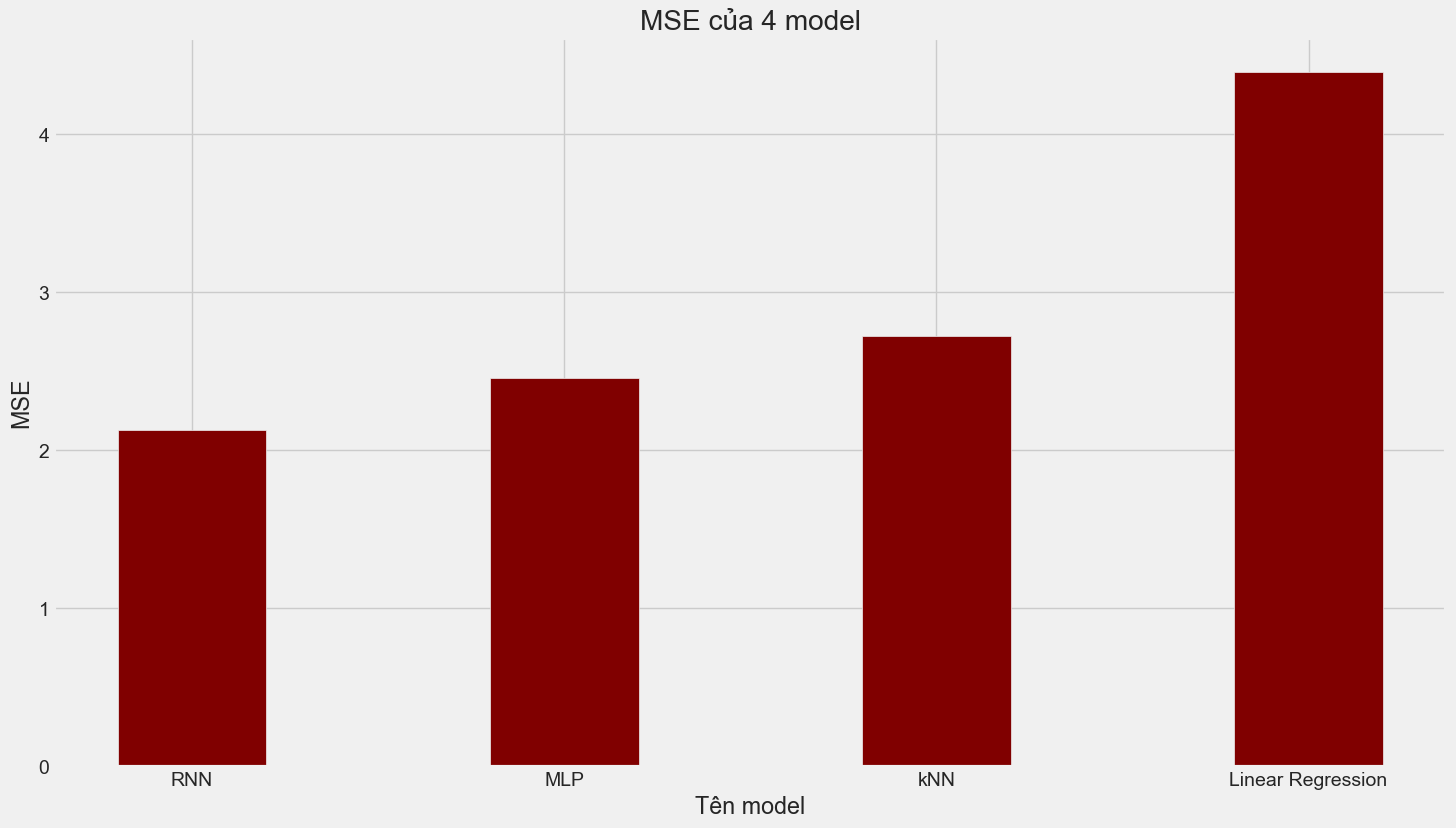

In [40]:
plt.figure(figsize=(16,9))
plt.title('MSE của 4 model')
plt.xlabel('Tên model')
plt.ylabel('MSE')
plt.bar(name, mse, color ='maroon',
        width = 0.4)

## Sử dụng L1 L2 tránh Overfitting

In [47]:
# Tạo RNN model với L1 L2
def createModelRNNwithL1L2(train_X, time_steps=840, out_length=14):
    model = Sequential()
    model.add(SimpleRNN(100, return_sequences=True, input_shape=(train_X.shape[1], 1), recurrent_regularizer='l1_l2'))
    model.add(SimpleRNN(50, return_sequences=False, recurrent_regularizer='l1_l2'))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return model

In [48]:
# build model RNN
modelRNNL1L2 = createModelRNNwithL1L2(train_X1)
modelRNNL1L2.summary()
modelRNNL1L2.fit(train_X1, train_y1, batch_size=8, epochs=2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 840, 100)          10200     
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 50)                7550      
                                                                 
 dense_7 (Dense)             (None, 14)                714       
                                                                 
Total params: 18,464
Trainable params: 18,464
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
122/122 [==============================] - 25s 191ms/step - loss: 8.3256
Epoch 2/2
122/122 [==============================] - 27s 218ms/step - loss: 2.3448


In [49]:
# tạo tập test_inputs RNN
test_inputs = df[len(df) - len(test_df) - 840 :]
test_X1, test_y1 = preprocess_pipeline.transform(test_inputs)
test_X1.shape, test_y1.shape

((1, 840, 1), (1, 14))

In [50]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu của RNN
time_start = time.time()

pred_test_RNN_l1l2 = modelRNNL1L2.predict(test_X1)

time_end = time.time()

time_test_RNN = time_end - time_start

pred_test_RNN_l1l2 = scaler.inverse_transform(pred_test_RNN_l1l2)
pred_test_RNN_l1l2 = [round(i,1) for i in pred_test_RNN_l1l2[0]]
print(pred_test_RNN_l1l2)


1/1 [==============================] - 0s 385ms/step
[89.9, 89.5, 88.5, 88.5, 88.3, 88.8, 91.2, 91.0, 91.2, 89.8, 89.3, 89.7, 89.3, 86.2]


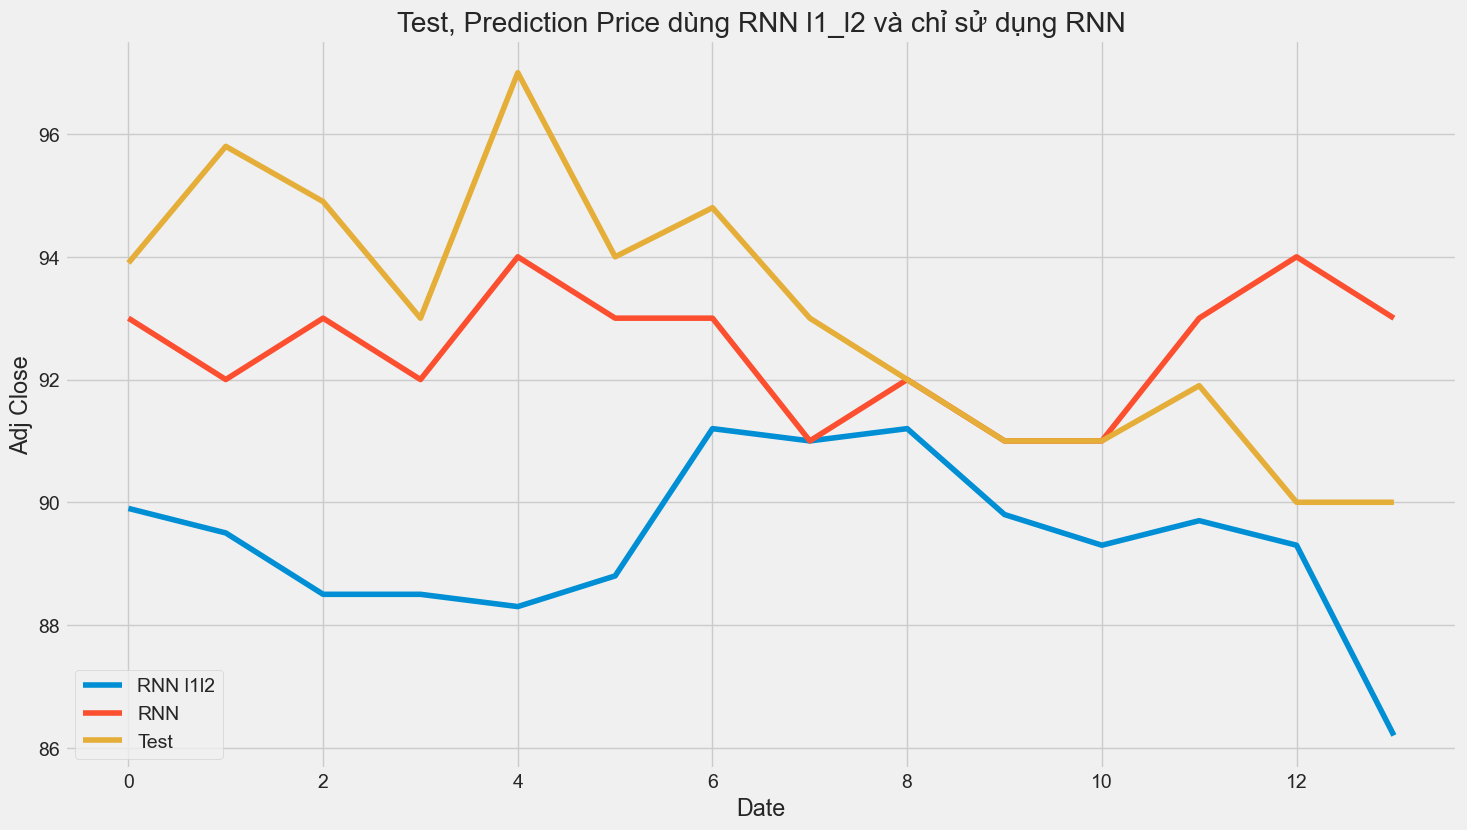

In [51]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price dùng RNN l1_l2 và chỉ sử dụng RNN')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(pred_test_RNN_l1l2)
plt.plot(pred_test1)

plt.plot(test)
plt.legend(['RNN l1l2','RNN','Test'], loc='lower left')
plt.show()

## Tìm feature quan trong

<AxesSubplot:>

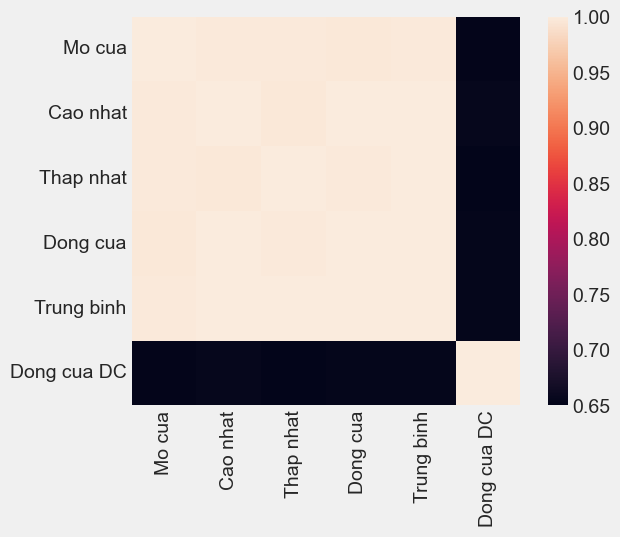

In [52]:
import seaborn as sb
correlation_values=df.corr()
sb.heatmap(correlation_values,square=True)

In [53]:
# tạo dataframe chỉ bao gồm cột index và cột Adj Close Price 
def createDataFrame(df):
    return df.filter(['Mo cua'])

real_train_df = createDataFrame(train_df)
real_train_df.shape

(1826, 1)

In [54]:
scaled_train_data = reshapeForModel(scaled_train_data)

In [55]:
preprocess_pipeline_3 = Pipeline([
    ('dropper', FunctionTransformer(createDataFrame)),
    ('scaler', MinMaxScaler()),
    ('reshape', FunctionTransformer(reshapeForModel)),
    ('createTrain', FunctionTransformer(createTrainX_y_RNN)),
])

train_X3, train_y3 = preprocess_pipeline_3.fit_transform(train_df)
train_X3.shape, train_y3.shape

((973, 840, 1), (973, 14))

In [56]:
# build model RNN
model1 = createModelRNN(train_X3)

model1.summary()

time_start = time.time()

model1.fit(train_X3, train_y1, batch_size=32, epochs=2)

time_end = time.time()

time_train_RNN = time_end - time_start

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 840, 200)          40400     
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 50)                12550     
                                                                 
 dense_8 (Dense)             (None, 14)                714       
                                                                 
Total params: 53,664
Trainable params: 53,664
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
31/31 [==============================] - 17s 496ms/step - loss: 0.0243
Epoch 2/2
31/31 [==============================] - 15s 483ms/step - loss: 0.0017


In [57]:
# tạo tập test_inputs RNN
test_inputs = df[len(df) - len(test_df) - 840 :]
test_X3, test_y3 = preprocess_pipeline.transform(test_inputs)
test_X3.shape, test_y3.shape

((1, 840, 1), (1, 14))

In [58]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu của RNN
time_start = time.time()

pred_test1 = model1.predict(test_X3)

time_end = time.time()

time_test_RNN = time_end - time_start

pred_test1 = scaler.inverse_transform(pred_test1)
pred_test1 = [round(i) for i in pred_test1[0]]
print(pred_test1)


1/1 [==============================] - 1s 705ms/step
[94, 95, 96, 95, 95, 94, 94, 92, 94, 97, 95, 96, 98, 96]


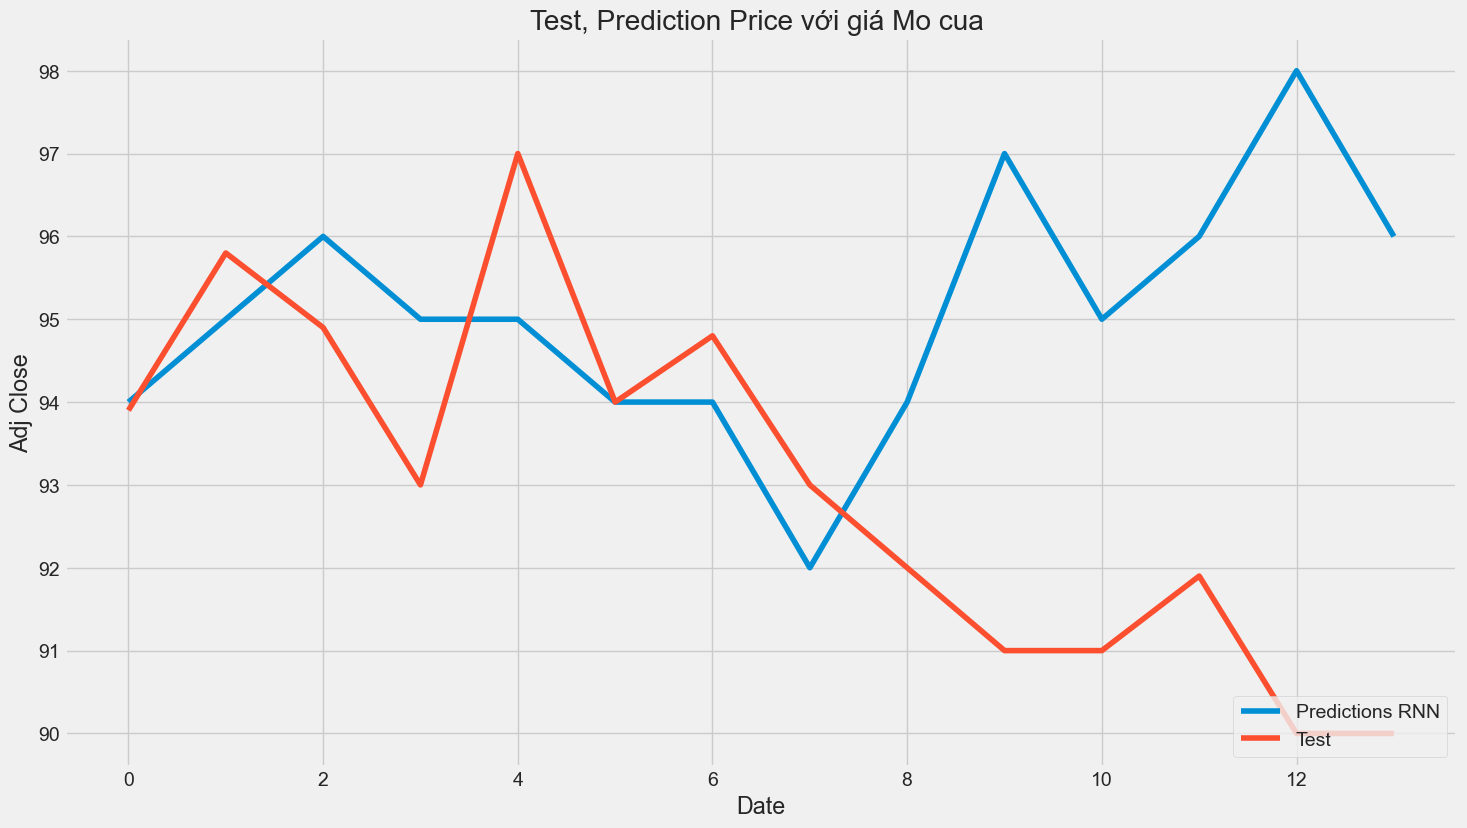

In [59]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price với giá Mo cua ')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(pred_test1)

plt.plot(test)
plt.legend(['Predictions RNN','Test'], loc='lower right')
plt.show()

## LSTM

In [60]:
# Tạo LSTM model
def createModelLSTM(train_X, time_steps=840, out_length=14):
    model = Sequential()
    model.add(LSTM(200, return_sequences=False, input_shape=(train_X.shape[1], 1)))
#     model.add(LSTM(100, return_sequences=False))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return model

In [61]:
# build model LSTM
modelLSTM = createModelLSTM(train_X1)
modelLSTM.summary()
modelLSTM.fit(train_X1, train_y1, batch_size=8, epochs=2)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense_9 (Dense)             (None, 14)                2814      
                                                                 
Total params: 164,414
Trainable params: 164,414
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
122/122 [==============================] - 60s 460ms/step - loss: 0.0115
Epoch 2/2
122/122 [==============================] - 55s 451ms/step - loss: 0.0014


In [62]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu của LSTM
time_start = time.time()

pred_test1 = modelLSTM.predict(test_X1)

time_end = time.time()

time_test_RNN = time_end - time_start

pred_test1 = scaler.inverse_transform(pred_test1)
pred_test1 = [round(i) for i in pred_test1[0]]
print(pred_test1)


1/1 [==============================] - 1s 940ms/step
[98, 98, 97, 98, 99, 99, 99, 99, 99, 99, 98, 99, 99, 100]


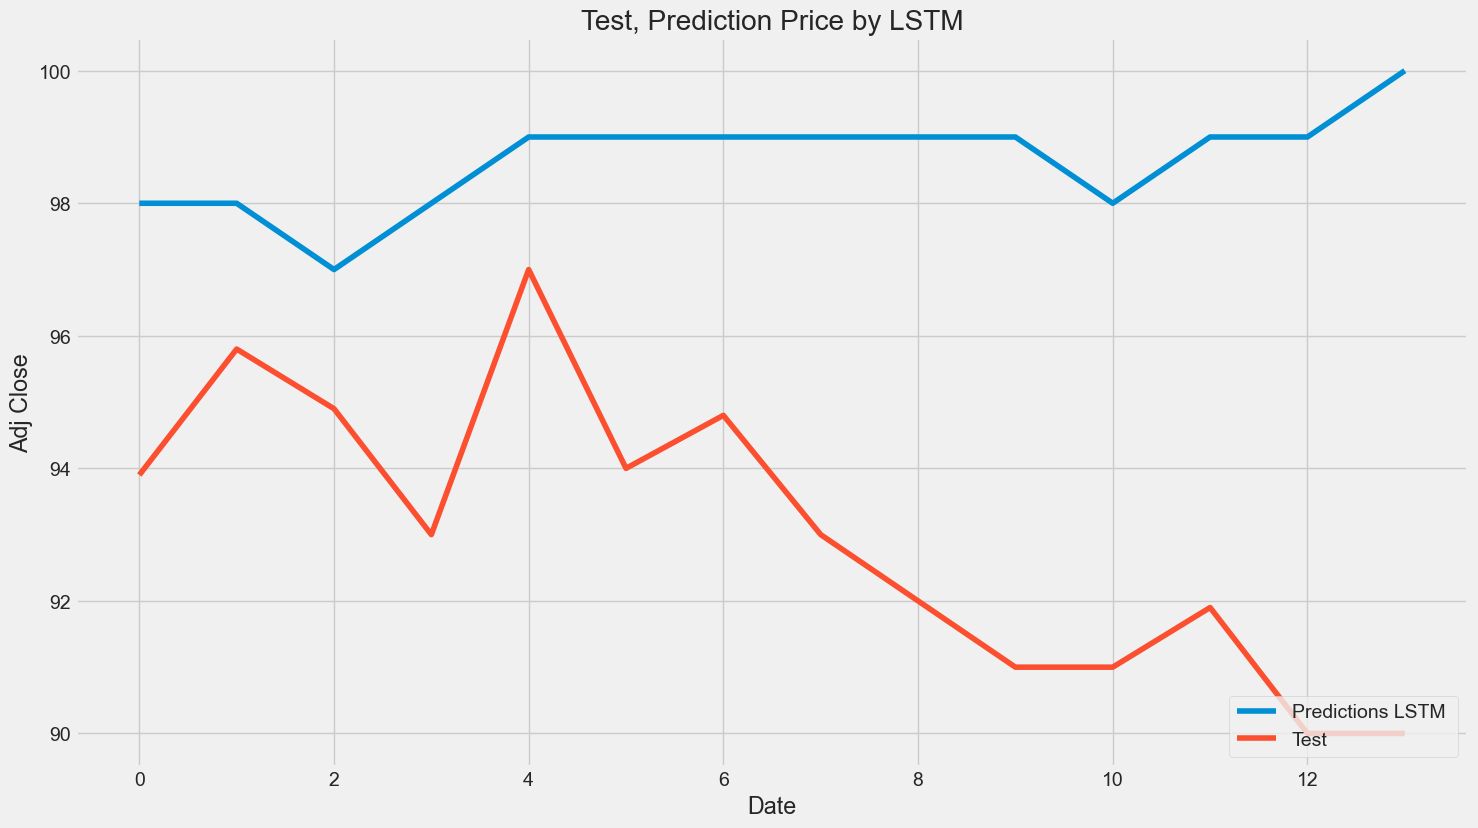

In [63]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price by LSTM')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(pred_test1)

plt.plot(test)
plt.legend(['Predictions LSTM ','Test'], loc='lower right')
plt.show()

## CNN

In [64]:
# Tạo CNN model
def createModelCNN(train_X, time_steps=840, out_length=14):
    model = Sequential()
    model.add(Conv1D(200, kernel_size=5, input_shape=(train_X.shape[1], 1)))
    model.add(Conv1D(100, kernel_size=5,))
    model.add(Dense(out_length))
    model.compile(optimizer='adam', loss='mse')

    return model

In [65]:
# build model CNN
modelCNN = createModelCNN(train_X1)
modelCNN.summary()
modelCNN.fit(train_X1, train_y1, batch_size=1, epochs=1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 836, 200)          1200      
                                                                 
 conv1d_1 (Conv1D)           (None, 832, 100)          100100    
                                                                 
 dense_10 (Dense)            (None, 832, 14)           1414      
                                                                 
Total params: 102,714
Trainable params: 102,714
Non-trainable params: 0
_________________________________________________________________
973/973 [==============================] - 10s 10ms/step - loss: 0.0242


In [66]:
# dự đoán tập inputs và chuẩn hóa ngược lại về dạng giá ban đầu của CNN
time_start = time.time()

pred_test1 = modelCNN.predict(test_X1)

time_end = time.time()

time_test_RNN = time_end - time_start

print(pred_test1)

pred_test1 = scaler.inverse_transform(pred_test1[0])
pred_test1 = [round(i) for i in pred_test1[0]]
print(pred_test1)


1/1 [==============================] - 0s 197ms/step
[[[0.28227136 0.260897   0.27261296 ... 0.28262    0.3088972  0.28444526]
  [0.2815783  0.26013803 0.27351525 ... 0.2825014  0.30793947 0.284194  ]
  [0.2813543  0.26041922 0.2736057  ... 0.28264728 0.30880457 0.2840231 ]
  ...
  [0.22621009 0.22177994 0.22939149 ... 0.22638431 0.21655935 0.21642695]
  [0.22696042 0.2230292  0.22850484 ... 0.22591081 0.21780433 0.21607427]
  [0.22671387 0.2224704  0.22726214 ... 0.22575065 0.21735701 0.21743713]]]
[73, 71, 72, 73, 73, 74, 72, 73, 71, 71, 74, 73, 75, 73]


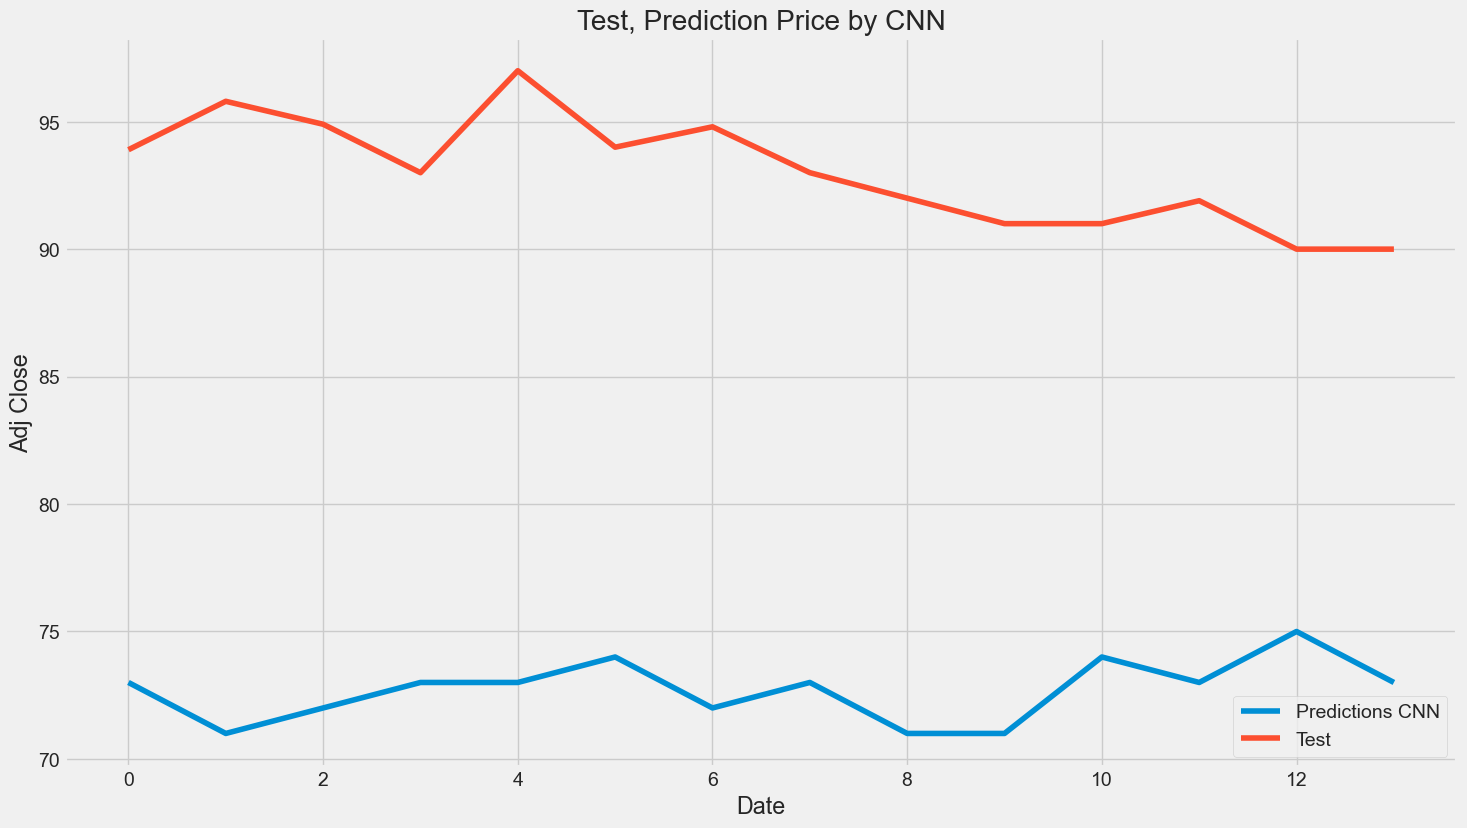

In [67]:
plt.figure(figsize=(16,9))
plt.title('Test, Prediction Price by CNN')
plt.xlabel('Date')
plt.ylabel('Adj Close')
plt.plot(pred_test1)

plt.plot(test)
plt.legend(['Predictions CNN','Test'], loc='lower right')
plt.show()